#Import Relevant Libraries


In [ ]:
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import gensim.downloader as api

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import string
import nltk
import datetime

from google.colab import files
from wordcloud import WordCloud, STOPWORDS

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from keras import layers, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, LearningRateScheduler
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.layers import TextVectorization, Bidirectional
from keras.preprocessing.sequence import pad_sequences



In [ ]:

# Download the necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Import Dataset from Kaggle

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
# Upload your own API Token from kaggle in Colab before running this cell
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

 98% 40.0M/41.0M [00:00<00:00, 215MB/s]
100% 41.0M/41.0M [00:00<00:00, 208MB/s]


In [ ]:
! mkdir data

In [ ]:
! unzip fake-and-real-news-dataset.zip -d data

Archive:  fake-and-real-news-dataset.zip
  inflating: data/Fake.csv           
  inflating: data/True.csv           


# Helper Functions

## Plot WordCloud

In [ ]:
# Function to plot WordCloud

def generate_wordcloud_subplot(df, label_value, subplot_position, max_words=1000, width=800, height=400):
    """
    Generate a word cloud for a specific label value and display it in a subplot.

    Args:
        df (DataFrame): The DataFrame containing text data and labels.
        label_value (int): The label value for which to generate the word cloud.
        subplot_position (int): The position of the subplot where the word cloud will be displayed.
        max_words (int, optional): Maximum number of words to include in the word cloud. Default is 1000.
        width (int, optional): Width of the word cloud image. Default is 800.
        height (int, optional): Height of the word cloud image. Default is 400.

    Returns:
        None
    """

    # Select the text subset for the specified label value
    text_subset = df[df.label == label_value].text

    # Define stopwords
    stopwords = set(STOPWORDS)

    # Create a WordCloud object with specified parameters
    wc = WordCloud(max_words=max_words, width=width, height=height, stopwords=stopwords)

    # Generate the word cloud from the selected text subset
    wc.generate(" ".join(text_subset))

    # Create a subplot and display the word cloud
    plt.subplot(subplot_position)
    plt.imshow(wc, interpolation='bilinear')

    # Set the title for the word cloud plot
    title = f'WordCloud for Label {label_value} ({("True" if label_value == 1 else "Fake")})'
    plt.title(title)


## Plot Confusion Matrix


In [ ]:
# Function to show the confusion matrix

def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], figsize=(6, 4)):
    """
    Plot a confusion matrix to visualize classification results.

    Args:
        y_true (array-like): True labels or ground truth.
        y_pred (array-like): Predicted labels.
        labels (list, optional): List of class labels for display. Default is ["Negative", "Positive"].
        figsize (tuple, optional): Figure size (width, height) in inches. Default is (6, 4).

    Returns:
        None
    """

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot the confusion matrix
    plt.figure(figsize=figsize)
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 12})
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.xticks(np.arange(len(labels)) + 0.5, labels, fontsize=10)
    plt.yticks(np.arange(len(labels)) + 0.5, labels, fontsize=10)
    plt.show()


## Plot Precision/Recall Results

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score

def calculate_results_as_dataframe(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall, and F1-score of a binary classification model
    and returns the results as a DataFrame.

    Args:
    -----
    y_true : true labels in the form of a 1D array
    y_pred : predicted labels in the form of a 1D array

    Returns a DataFrame with 'accuracy', 'precision', 'recall', and 'f1' as percentages with 2 decimal places.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall, and F1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'accuracy': [model_accuracy],
        'precision': [model_precision],
        'recall': [model_recall],
        'f1': [model_f1]
    })

    # Format the percentage columns with two decimal places
    results_df['accuracy'] = results_df['accuracy'].apply(lambda x: f'{x:.3f}%')
    results_df['precision'] = results_df['precision'].apply(lambda x: f'{x:.3f}')
    results_df['recall'] = results_df['recall'].apply(lambda x: f'{x:.3f}')
    results_df['f1'] = results_df['f1'].apply(lambda x: f'{x:.3f}')

    return results_df

# Exploratory Data Analysis

## Load Data

In [ ]:
# Load Data

fake_df = pd.read_csv("/content/data/Fake.csv")
true_df = pd.read_csv("/content/data/True.csv")

In [ ]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake_df.shape, true_df.shape

((23481, 4), (21417, 4))

## Merge Data

In [ ]:
# Merge data

# Set label 0 to fake and 1 to real
fake_df["label"] = 0
true_df["label"] = 1

news_df = pd.concat([fake_df, true_df])
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


## Duplicated Rows

In [ ]:
# Checking duplicate rows

duplicate = news_df[news_df.duplicated()]

print(f"Nr. of Duplicated Rows :{duplicate.shape[0]} rows")

# Print the resultant Dataframe
duplicate

Nr. of Duplicated Rows :209 rows


,title,text,subject,date,label
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017",0
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017",0
14925,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015",0
445,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017",1
778,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017",1
...,...,...,...,...,...
21228,France unveils labor reforms in first step to ...,PARIS (Reuters) - French President Emmanuel Ma...,worldnews,"August 31, 2017",1
21263,Guatemala top court sides with U.N. graft unit...,GUATEMALA CITY (Reuters) - Guatemala s top cou...,worldnews,"August 29, 2017",1
21290,"Europeans, Africans agree renewed push to tack...",PARIS (Reuters) - Europe s big four continen...,worldnews,"August 28, 2017",1
21353,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,"August 25, 2017",1


In [ ]:
# Removing duplicates

# Get the number of rows before removing duplicates
num_rows_before = len(news_df)

# Drop duplicate rows based on all columns
news_df = news_df.drop_duplicates()

# Get the number of rows after removing duplicates
num_rows_after = len(news_df)

# Print the number of rows before and after
print(f"Number of rows before removing duplicates: {num_rows_before}")
print(f"Number of rows after removing duplicates: {num_rows_after}")

Number of rows before removing duplicates: 44898
Number of rows after removing duplicates: 44689


## Missing Data

In [ ]:
# Check for missing data

print('Number of NaN values present: ' + str(news_df.isnull().sum().sum()))

Number of NaN values present: 0


In [ ]:
# Calculating missing values in the dataset

missing_values = news_df.isnull().sum()

missing_per = (missing_values/news_df.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True)
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)

missing_table

,Total Missing Values,Missing %
title,0,0.0
text,0,0.0
subject,0,0.0
date,0,0.0
label,0,0.0


## Unique Values

It is interesting to see that around 6'000 titles and texts are repetated but have different labels

In [ ]:
# Check the Nr. of Unique Values

column_dict = {
    'Column Name': [],
    'Unique Values': []
}

for column in news_df.columns:
    unique_values = news_df[column].nunique()
    column_dict['Column Name'].append(column)
    column_dict['Unique Values'].append(unique_values)

unique_df = pd.DataFrame(column_dict)
unique_df

,Column Name,Unique Values
0,title,38729
1,text,38646
2,subject,8
3,date,2397
4,label,2


## Plots

### Labels

In [ ]:
# Check value counts

news_df['label'].value_counts()

0    23478
1    21211
Name: label, dtype: int64

In [ ]:
# Plot labels distribution

# Define new colors
colors = ['#FF5733', '#33FF57']  # Custom colors

labels = ['FAKE','TRUE']
value_counts = news_df['label'].value_counts()
values = value_counts / len(news_df)

# Create the Pie chart
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hole=0.3,
    hoverinfo='label+percent',
    textinfo='percent',
    textfont_size=20,
    marker=dict(colors=colors, line=dict(color='#000000', width=2))
)])

# Update the layout
fig.update_layout(
    title="Labels Distribution",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
    width=800,
    height=600
)

# Show the figure
fig.show()

### Subjects

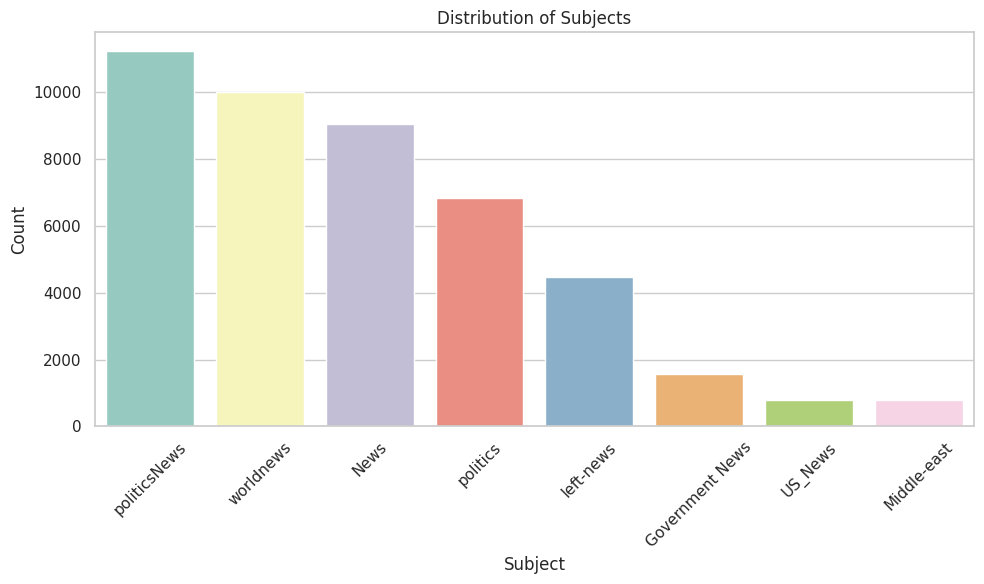

In [ ]:
# Plot subjects distribution

# Set the style of the plot
sns.set(style="whitegrid")

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create the bar chart
sns.countplot(data=news_df, x='subject', order=news_df['subject'].value_counts().index, palette="Set3")

# Add labels and title
plt.xlabel("Subject")
plt.ylabel("Count")
plt.title("Distribution of Subjects")

# Rotate x-axis labels for better readability (adjust angle as needed)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


### Subjects vs Labels

In [ ]:
# Plot subjects distribution by label

data = news_df.groupby(['subject', 'label']).size().reset_index(name='count')

# Define colors for real (1) and fake (0) labels
colors = {0: 'red', 1: 'green'}

# Sort the data by count in descending order
data = data.sort_values(by='count', ascending=False)

# Create a bar chart with hover text
fig = go.Figure()

for label, color in colors.items():
    subset = data[data['label'] == label]
    fig.add_trace(go.Bar(
        x=subset['subject'],
        y=subset['count'],
        name=f"Label {label}",
        marker_color=color,
        hovertext=subset['count'],  # Display count on hover
    ))

# Update layout
fig.update_layout(
    xaxis_title="Subject",
    yaxis_title="Count",
    title="Distribution of Subjects by Real (1) and Fake (0)",
    xaxis=dict(tickangle=45),  # Rotate x-axis labels for readability
)

# Show the interactive plot
fig.show()


### WordCloud

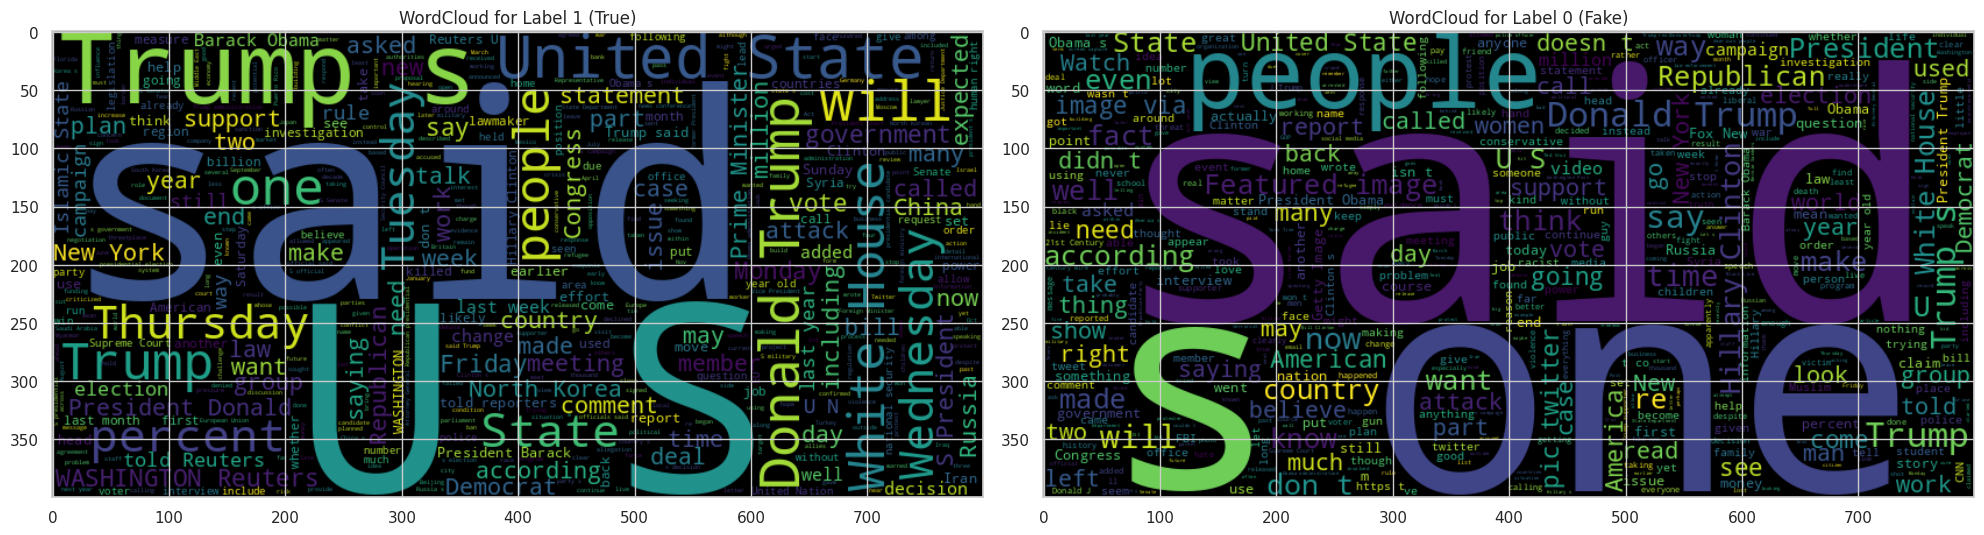

In [ ]:
# Plot WordCloud

# Create a 1x2 grid of subplots
plt.figure(figsize=(20, 10))

# Generate WordCloud for label_value = 1 (subplot 1)
generate_wordcloud_subplot(news_df, label_value=1, subplot_position=121)

# Generate WordCloud for label_value = 0 (subplot 2)
generate_wordcloud_subplot(news_df, label_value=0, subplot_position=122)

plt.tight_layout()  # Adjust spacing between subplots

plt.show()

# Preprocessing

In [ ]:
# Copy the df as df_model

df_model = news_df.copy()

In [ ]:
df_model.head(2)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0


## Select Columns

In [ ]:
# Drop columns

df_model.drop(["date", "subject"], axis = 1, inplace=True)

In [ ]:
df_model.head(2)

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0


In [ ]:
# Combine string columns and fill in the NaN with empty string

df_model['combined_features'] = df_model['title'] + ' ' + df_model['text']

In [ ]:
# Cleaned Dataset

df_model.head()

,title,text,label,combined_features
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0,Pope Francis Just Called Out Donald Trump Dur...


## Preprocess Columns

In [ ]:
# Clean text function

# Define the text cleaning function
def clean_text(text):
    # Remove punctuation
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')

    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove non-alphabetic tokens (numbers and special characters)
    words_only = [word for word in tokens if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    without_stopwords = [word for word in words_only if word not in stop_words]

    # Lemmatize words
    lemma = WordNetLemmatizer()
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords]

    # Join the cleaned words back into a string
    cleaned = ' '.join(lemmatized)

    return cleaned

# Apply the clean_text function to the specified columns in the DataFrame
df_model['title'] = df_model['title'].apply(clean_text)
df_model['text'] = df_model['text'].apply(clean_text)
df_model['combined_features'] = df_model['combined_features'].apply(clean_text)



In [ ]:
# Cleaned Dataset

df_model.head()

,title,text,label,combined_features
0,donald trump sends embarrassing new year eve m...,donald trump wish american happy new year leav...,0,donald trump sends embarrassing new year eve m...
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,0,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...,0,sheriff david clarke becomes internet joke thr...
3,trump obsessed even obama name coded website i...,christmas day donald trump announced would bac...,0,trump obsessed even obama name coded website i...
4,pope francis called donald trump christmas speech,pope francis used annual christmas day message...,0,pope francis called donald trump christmas spe...


In [ ]:
# Checking duplicate rows

duplicate_1 = df_model[df_model.duplicated()]

print(f"Nr. of Duplicated Rows :{duplicate_1.shape[0]} rows")

# Print the resultant Dataframe
duplicate_1

Nr. of Duplicated Rows :5854 rows


,title,text,label,combined_features
10924,medium ignores time bill clinton fired fbi dir...,year history one f b director fired tuesday pr...,0,medium ignores time bill clinton fired fbi dir...
14244,george soros board member chairman firm runnin...,george soros seems sticking nose everything el...,0,george soros board member chairman firm runnin...
15892,house intel slap subpoena mccain institute ass...,please see previous report mccain institute as...,0,house intel slap subpoena mccain institute ass...
15893,priceless watch msnbc host shocked response go...,priceless video show control left come corrupt...,0,priceless watch msnbc host shocked response go...
15895,morning joe panel say nikki haley embarrassed ...,really interesting hear panel go ballistic nik...,0,morning joe panel say nikki haley embarrassed ...
...,...,...,...,...
21356,trump call egypt sisi say keen overcome obstacle,cairo reuters u president donald trump called ...,1,trump call egypt sisi say keen overcome obstac...
21402,exclusive trump afghan decision may increase u...,board u military aircraft reuters u air force ...,1,exclusive trump afghan decision may increase u...
21403,u put pressure pakistan help afghan war,washington reuters united state suggested tues...,1,u put pressure pakistan help afghan war washin...
21405,trump talk tough pakistan terrorist haven opti...,islamabad reuters outlining new strategy war a...,1,trump talk tough pakistan terrorist haven opti...


Looks like after preprocessing, we have still duplicated rows. Let's keep removing them

In [ ]:
# Check duplicated rows with row number 10924

# Get the values in row 10924 for the specified columns
title_value = duplicate_1.loc[10924, 'title']
text_value = duplicate_1.loc[10924, 'text']
label_value = duplicate_1.loc[10924, 'label']
combined_features_value = duplicate_1.loc[10924, 'combined_features']

# Filter the DataFrame based on the specified conditions
filtered_rows = duplicate_1[(duplicate_1['title'] == title_value) &
                    (duplicate_1['text'] == text_value) &
                    (duplicate_1['label'] == label_value) &
                    (duplicate_1['combined_features'] == combined_features_value)]

# Print the filtered rows
filtered_rows

,title,text,label,combined_features
10924,medium ignores time bill clinton fired fbi dir...,year history one f b director fired tuesday pr...,0,medium ignores time bill clinton fired fbi dir...
18650,medium ignores time bill clinton fired fbi dir...,year history one f b director fired tuesday pr...,0,medium ignores time bill clinton fired fbi dir...
18654,medium ignores time bill clinton fired fbi dir...,year history one f b director fired tuesday pr...,0,medium ignores time bill clinton fired fbi dir...


In [ ]:
# Removing duplicates

# Get the number of rows before removing duplicates
num_rows_before = len(df_model)

# Drop duplicate rows based on all columns
df_model = df_model.drop_duplicates()

# Get the number of rows after removing duplicates
num_rows_after = len(df_model)

# Print the number of rows before and after
print(f"Number of rows before removing duplicates: {num_rows_before}")
print(f"Number of rows after removing duplicates: {num_rows_after}")

Number of rows before removing duplicates: 44689
Number of rows after removing duplicates: 38835


In [ ]:
# Check the Nr. of Unique Values

column_dict = {
    'Column Name': [],
    'Unique Values': []
}

for column in df_model.columns:
    unique_values = df_model[column].nunique()
    column_dict['Column Name'].append(column)
    column_dict['Unique Values'].append(unique_values)

unique_df = pd.DataFrame(column_dict)
unique_df

,Column Name,Unique Values
0,title,38676
1,text,38338
2,label,2
3,combined_features,38835


## Plot Labels Distribution

In [ ]:
 # Check value counts

 df_model['label'].value_counts()

1    20930
0    17905
Name: label, dtype: int64

In [ ]:
# Plot labels distribution with the clean data

# Define new colors
colors = ['#33FF57', '#FF5733']  # Custom colors

labels = ['TRUE','FAKE']
value_counts = df_model['label'].value_counts()
values = value_counts / len(df_model)

# Create the Pie chart
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hole=0.3,
    hoverinfo='label+percent',
    textinfo='percent',
    textfont_size=20,
    marker=dict(colors=colors, line=dict(color='#000000', width=2))
)])

# Update the layout
fig.update_layout(
    title="Labels Distribution",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
    width=800,
    height=600
)

# Show the figure
fig.show()

In [ ]:
# Order the columns

df_model = df_model[["title", "text", "combined_features","label"]]

In [ ]:
# Save the DataFrame to a parquet file

df_model = df_model.to_parquet("clean_data.parquet", compression="brotli")


# Modeling

## Load Clean Dataframe

In [ ]:
# Load the parquet file back into a DataFrame

clean_df = pd.read_parquet("clean_data.parquet")
clean_df.head()

,title,text,combined_features,label
0,donald trump sends embarrassing new year eve m...,donald trump wish american happy new year leav...,donald trump sends embarrassing new year eve m...,0
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,drunk bragging trump staffer started russian c...,0
2,sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...,sheriff david clarke becomes internet joke thr...,0
3,trump obsessed even obama name coded website i...,christmas day donald trump announced would bac...,trump obsessed even obama name coded website i...,0
4,pope francis called donald trump christmas speech,pope francis used annual christmas day message...,pope francis called donald trump christmas spe...,0


## Train/Test Split

In [ ]:
# Create a shuffled df for a good labels distribution

# Set a random seed for reproducibility
random_seed = 42

print("Before shuffling:", clean_df.shape)

# Shuffle the DataFrame with the specified random seed
shuffled_df = clean_df.sample(frac=1, random_state=random_seed)

print("After shuffling:", shuffled_df.shape)

Before shuffling: (38835, 4)
After shuffling: (38835, 4)


In [ ]:
# Create a train/val/test split and shuffle previously

X = shuffled_df["combined_features"]
y = shuffled_df["label"]

# Split the data into train, validation, and test sets (80% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_seed)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed)

# Display the shapes of the train, validation, and test sets
print("X_train shape:", X_train.shape)
print("X_validation shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_validation shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (27184,)
X_validation shape: (5825,)
X_test shape: (5826,)
y_train shape: (27184,)
y_validation shape: (5825,)
y_test shape: (5826,)


In [ ]:
y_train.value_counts()

1    14679
0    12505
Name: label, dtype: int64

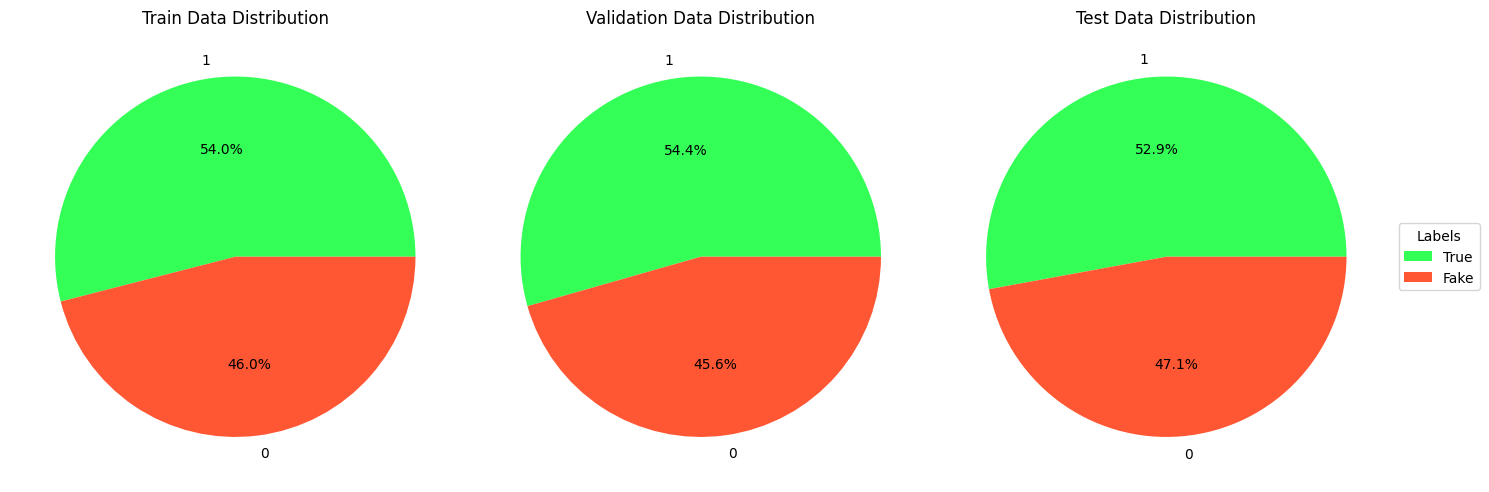

In [ ]:
# Get the distribution of the train/test split

# Get label counts for train, validation, and test data
train_label_counts = y_train.value_counts()
val_label_counts = y_val.value_counts()
test_label_counts = y_test.value_counts()

# Define custom colors
colors = ['#33FF57', '#FF5733']

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1: Train data distribution
wedges, texts, autotexts = axes[0].pie(train_label_counts, labels=train_label_counts.index, autopct='%1.1f%%', colors=colors)
axes[0].set_title('Train Data Distribution')

# Subplot 2: Validation data distribution
wedges, texts, autotexts = axes[1].pie(val_label_counts, labels=val_label_counts.index, autopct='%1.1f%%', colors=colors)
axes[1].set_title('Validation Data Distribution')

# Subplot 3: Test data distribution
wedges, texts, autotexts = axes[2].pie(test_label_counts, labels=test_label_counts.index, autopct='%1.1f%%', colors=colors)
axes[2].set_title('Test Data Distribution')

# Add a legend manually
legend_labels = ['True', 'Fake']
axes[2].legend(legend_labels, title="Labels", loc="center left", bbox_to_anchor=(1, 0.5))

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

## Vectorization

In [ ]:
# Create a TextVectorization layer without specifying max_tokens to get the Vocabulary Size

text_vectorizer = TextVectorization(split="whitespace",
                                    output_mode="int")

# Fit the text vectorizer
text_vectorizer.adapt(X)

# Get the number of unique tokens in the vocabulary
vocab_size = len(text_vectorizer.get_vocabulary())

# Print the vocabulary size
print("Vocabulary size:", vocab_size)

Vocabulary size: 97521


In [ ]:
# Setup text vectorization with custom variables

# Set the maximum vocabulary size
max_vocab_size = 10000

# Calculate the maximum sequence length based on the average number of tokens in training data
average_tokens_per_sequence = round(sum([len(text.split()) for text in X_train]) / len(X_train))

# Create and configure the TextVectorization layer
text_vectorizer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode="int",
    output_sequence_length=average_tokens_per_sequence,
    pad_to_max_tokens=True
)

# Adapt the TextVectorization layer to the training text
if len(X_train) > 0:
    text_vectorizer.adapt(X_train)
else:
    print("Warning: X_train is empty, adaptation skipped.")

##Embedding

In [2]:
# Create embedding with Keras Layer

tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_size,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=average_tokens_per_sequence)

## Models

### Baseline Model

In [ ]:
# Create a Baseline Model using Gridsearch with few parameters

# Define the pipeline with TF-IDF and Multinomial Naive Bayes
baseline_model = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Define hyperparameters and their possible values for grid search
param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],
    'clf__alpha': [0.1, 0.5, 1.0]
}

# Create a grid search object
grid_search = GridSearchCV(baseline_model, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
baseline_best_params = grid_search.best_params_
baseline_best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
baseline_test_accuracy = baseline_best_model.score(X_val, y_val)

print(f"Baseline Model Best Parameters: {baseline_best_params}")
print(f"Baseline Model Test Accuracy: {baseline_test_accuracy*100:.2f}%")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Baseline Model Best Parameters: {'clf__alpha': 0.1, 'tfidf__max_features': 10000}
Baseline Model Test Accuracy: 93.65%


In [ ]:
# Make predictions

baseline_prediction = baseline_best_model.predict(X_test)
baseline_prediction[:5]

array([1, 0, 0, 1, 1])

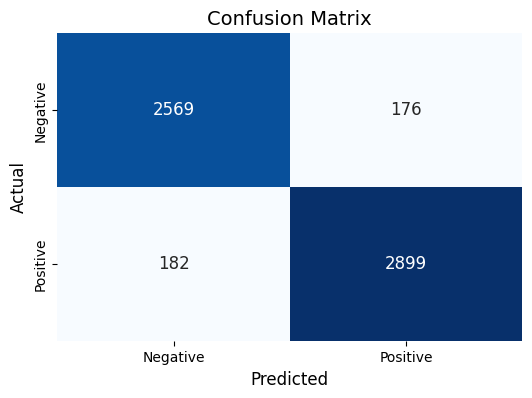

In [ ]:
# Plot confusion matrix

baseline_cm = plot_confusion_matrix(y_test, baseline_prediction)
baseline_cm

In [ ]:
# Show results

baseline_results = calculate_results_as_dataframe(y_test, baseline_prediction)

baseline_results

,accuracy,precision,recall,f1
0,93.855%,0.939,0.939,0.939


In [ ]:
baseline_results["model"] = "Baseline Gridsearch"
baseline_results["architecture"] = "Multinomial Naive Bayes"
baseline_results["tokenizer/vectorizer"] = "TfidfVectorizer"
baseline_results["embedding"] = "None"

baseline_results

,accuracy,precision,recall,f1,model,architecture,tokenizer/vectorizer,embedding
0,93.855%,0.939,0.939,0.939,Baseline Gridsearch,Multinomial Naive Bayes,TfidfVectorizer,None


### Basic RNN Model

In [ ]:
# Build the model

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

keras_model = tf.keras.Model(inputs, outputs)

# Compile model
keras_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
keras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 239)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 239, 128)          1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (4.

In [ ]:
# Fit the model

callbacks = [ModelCheckpoint(filepath='keras_model', save_best_only=True, save_format='tf'),
             EarlyStopping(patience=4, monitor='val_loss', restore_best_weights = True),
             ReduceLROnPlateau(factor=0.2, patience=2, monitor='val_loss'),
             CSVLogger('keras_training_log.csv')]


keras_model_history = keras_model.fit(X_train,
                                      y_train,
                                      epochs=20,
                                      validation_data=(X_val, y_val),
                                      callbacks=callbacks)

Epoch 1/20
850/850 [==============================] - 25s 28ms/step - loss: 0.2689 - accuracy: 0.9240 - val_loss: 0.1090 - val_accuracy: 0.9732 - lr: 0.0010
Epoch 2/20
850/850 [==============================] - 24s 28ms/step - loss: 0.0722 - accuracy: 0.9844 - val_loss: 0.0599 - val_accuracy: 0.9842 - lr: 0.0010
Epoch 3/20
850/850 [==============================] - 24s 28ms/step - loss: 0.0384 - accuracy: 0.9919 - val_loss: 0.0423 - val_accuracy: 0.9882 - lr: 0.0010
Epoch 4/20
850/850 [==============================] - 24s 28ms/step - loss: 0.0230 - accuracy: 0.9962 - val_loss: 0.0351 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 5/20
850/850 [==============================] - 24s 28ms/step - loss: 0.0142 - accuracy: 0.9978 - val_loss: 0.0315 - val_accuracy: 0.9909 - lr: 0.0010
Epoch 6/20
850/850 [==============================] - 24s 28ms/step - loss: 0.0087 - accuracy: 0.9989 - val_loss: 0.0302 - val_accuracy: 0.9906 - lr: 0.0010
Epoch 7/20
850/850 [==============================] - 23s 

In [ ]:
# Make predictions on input data (X_test) in form of probabilities

keras_probabilities = keras_model.predict(X_test)
keras_probabilities[:5]

183/183 [==============================] - 1s 5ms/step


array([[9.9999994e-01],
       [2.8425235e-09],
       [2.6378328e-02],
       [1.0000000e+00],
       [9.9999827e-01]], dtype=float32)

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats

# squeeze removes single dimensions
keras_prediction = tf.squeeze(tf.round(keras_probabilities))
keras_prediction[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 1., 1., 0., 0., 1., 1., 1.], dtype=float32)>

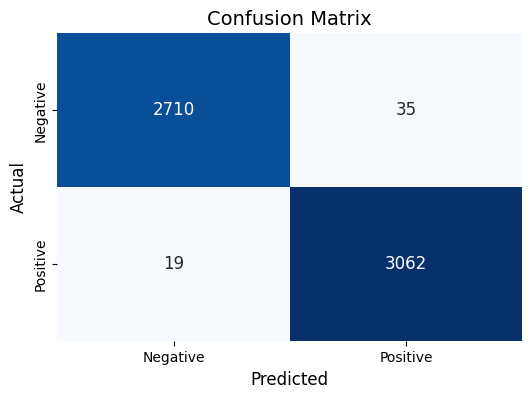

In [ ]:
# Plot confusion matrix

keras_cm = plot_confusion_matrix(y_test, keras_prediction)
keras_cm

In [ ]:
# Show results

keras_results = calculate_results_as_dataframe(y_test, keras_prediction)

keras_results

,accuracy,precision,recall,f1,architecture,tokenizer/vectorizer,embedding
0,99.073%,0.991,0.991,0.991,Basic RNN,TextVectorization,Keras Layer


In [ ]:
keras_results["model"] = "Basic Keras"
keras_results["architecture"] = "Basic RNN"
keras_results["tokenizer/vectorizer"] = "TextVectorization"
keras_results["embedding"] = "Keras Layer"

keras_results

,accuracy,precision,recall,f1,architecture,tokenizer/vectorizer,embedding,model
0,99.073%,0.991,0.991,0.991,Basic RNN,TextVectorization,Keras Layer,Basic Keras


### LSTM Model


In [ ]:
# Build the model

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

lstm_model = tf.keras.Model(inputs, outputs)

# Compile model
lstm_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
lstm_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 239)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 239, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [ ]:
# Fit the model
callbacks = [ModelCheckpoint(filepath='lstm_model', save_best_only=True, save_format='tf'),
             EarlyStopping(patience=4, monitor='val_loss', restore_best_weights = True),
             ReduceLROnPlateau(factor=0.2, patience=2, monitor='val_loss'),
             CSVLogger('lstm_training_log.csv')]


lstm_model_history = lstm_model.fit(X_train,
                                      y_train,
                                      epochs=20,
                                      validation_data=(X_val, y_val),
                                      callbacks=callbacks)

Epoch 1/20
850/850 [==============================] - 198s 229ms/step - loss: 0.1040 - accuracy: 0.9696 - val_loss: 0.2383 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 2/20
850/850 [==============================] - 198s 233ms/step - loss: 0.0769 - accuracy: 0.9804 - val_loss: 0.1074 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 3/20
850/850 [==============================] - 190s 224ms/step - loss: 0.1218 - accuracy: 0.9580 - val_loss: 0.2287 - val_accuracy: 0.9555 - lr: 0.0010
Epoch 4/20
850/850 [==============================] - 196s 230ms/step - loss: 0.1044 - accuracy: 0.9734 - val_loss: 0.0990 - val_accuracy: 0.9679 - lr: 0.0010
Epoch 5/20
850/850 [==============================] - 191s 225ms/step - loss: 0.0427 - accuracy: 0.9884 - val_loss: 0.0944 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 6/20
850/850 [==============================] - 190s 224ms/step - loss: 0.0608 - accuracy: 0.9838 - val_loss: 0.0846 - val_accuracy: 0.9748 - lr: 0.0010
Epoch 7/20
850/850 [==========================

In [ ]:
# Make predictions on input data (X_test) in form of probabilities

lstm_probabilities = lstm_model.predict(X_test)
lstm_probabilities[:5]

183/183 [==============================] - 10s 54ms/step


array([[9.999716e-01],
       [3.436359e-05],
       [1.938219e-04],
       [9.999938e-01],
       [9.999914e-01]], dtype=float32)

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats

# squeeze removes single dimensions
lstm_prediction = tf.squeeze(tf.round(lstm_probabilities))
lstm_prediction[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 1., 1., 0., 0., 1., 1., 1.], dtype=float32)>

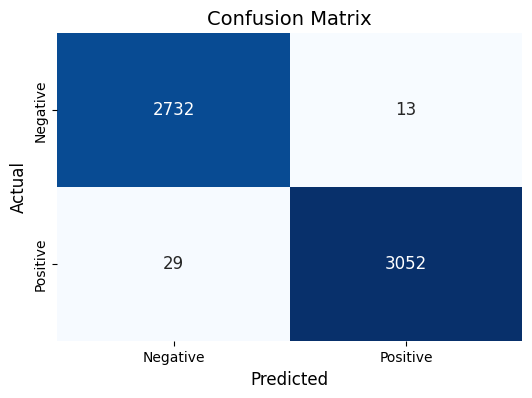

In [ ]:
# Plot confusion matrix

lstm_cm = plot_confusion_matrix(y_test, lstm_prediction)
lstm_cm

In [ ]:
# Show results

lstm_results = calculate_results_as_dataframe(y_test, lstm_prediction)
lstm_results

,accuracy,precision,recall,f1
0,99.279%,0.993,0.993,0.993


In [ ]:
lstm_results["model"] = "LSTM"
lstm_results["architecture"] = "LSTM RNN"
lstm_results["tokenizer/vectorizer"] = "TextVectorization"
lstm_results["embedding"] = "Keras Layer"

lstm_results

,accuracy,precision,recall,f1,model,architecture,tokenizer/vectorizer,embedding
0,99.279%,0.993,0.993,0.993,LSTM,LSTM RNN,TextVectorization,Keras Layer


### LSTM GRU Model

In [ ]:
# Build the model

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)


outputs = layers.Dense(1, activation="sigmoid")(x)

gru_model = tf.keras.Model(inputs, outputs)

# Compile model
gru_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
gru_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 239)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 239, 128)          1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [ ]:
# Fit the model

callbacks = [ModelCheckpoint(filepath='gru_model', save_best_only=True, save_format='tf'),
             EarlyStopping(patience=4, monitor='val_loss', restore_best_weights = True),
             ReduceLROnPlateau(factor=0.2, patience=2, monitor='val_loss'),
             CSVLogger('gru_training_log.csv')]


gru_model_history = gru_model.fit(X_train,
                                  y_train,
                                  epochs=20,
                                  validation_data=(X_val, y_val),
                                  callbacks=callbacks)

Epoch 1/20
850/850 [==============================] - 185s 214ms/step - loss: 0.1079 - accuracy: 0.9631 - val_loss: 0.0739 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 2/20
850/850 [==============================] - 184s 216ms/step - loss: 0.1271 - accuracy: 0.9711 - val_loss: 0.0403 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 3/20
850/850 [==============================] - 184s 216ms/step - loss: 0.0153 - accuracy: 0.9967 - val_loss: 0.0109 - val_accuracy: 0.9978 - lr: 0.0010
Epoch 4/20
850/850 [==============================] - 175s 206ms/step - loss: 0.0163 - accuracy: 0.9953 - val_loss: 0.0362 - val_accuracy: 0.9911 - lr: 0.0010
Epoch 5/20
850/850 [==============================] - 176s 207ms/step - loss: 0.0137 - accuracy: 0.9958 - val_loss: 0.0101 - val_accuracy: 0.9971 - lr: 0.0010
Epoch 6/20
850/850 [==============================] - 176s 207ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0091 - val_accuracy: 0.9978 - lr: 0.0010
Epoch 7/20
850/850 [==========================

In [ ]:
# Make predictions on input data (X_test) in form of probabilities

gru_probabilities = gru_model.predict(X_test)
gru_probabilities[:5]

183/183 [==============================] - 9s 45ms/step


array([[9.9982953e-01],
       [1.8104208e-04],
       [1.1786333e-03],
       [9.9988931e-01],
       [9.9986809e-01]], dtype=float32)

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats

# squeeze removes single dimensions
gru_prediction = tf.squeeze(tf.round(gru_probabilities))
gru_prediction[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 1., 1., 0., 0., 1., 1., 1.], dtype=float32)>

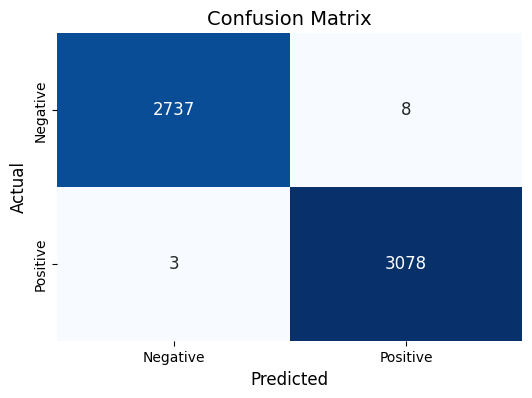

In [ ]:
# Plot confusion matrix

gru_cm = plot_confusion_matrix(y_test, gru_prediction)
gru_cm

In [ ]:
# Show results

gru_results = calculate_results_as_dataframe(y_test, gru_prediction)
gru_results

,accuracy,precision,recall,f1
0,99.811%,0.998,0.998,0.998


In [ ]:
gru_results["model"] = "GRU"
gru_results["architecture"] = "LSTM GRU RNN"
gru_results["tokenizer/vectorizer"] = "TextVectorization"
gru_results["embedding"] = "Keras Layer"

gru_results

,accuracy,precision,recall,f1,model,architecture,tokenizer/vectorizer,embedding
0,99.811%,0.998,0.998,0.998,GRU,LSTM GRU RNN,TextVectorization,Keras Layer


### Bidirectional Model

In [ ]:
# Build the model

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)

# bidirectional goes both ways so has double the parameters of a regular LSTM layer
x = layers.Bidirectional(layers.LSTM(64))(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

bi_model = tf.keras.Model(inputs, outputs)

# Compile model
bi_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
bi_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 239)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 239, 128)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable params: 1378945 (

In [ ]:
# Fit the model



callbacks = [ModelCheckpoint(filepath='bi_model', save_best_only=True, save_format='tf'),
             EarlyStopping(patience=4, monitor='val_loss', restore_best_weights = True),
             ReduceLROnPlateau(factor=0.2, patience=2, monitor='val_loss'),
             CSVLogger('bi_training_log.csv')]


bi_model_history = bi_model.fit(X_train,
                                y_train,
                                epochs=20,
                                validation_data=(X_val, y_val),
                                callbacks=callbacks)

Epoch 1/20
850/850 [==============================] - 341s 395ms/step - loss: 0.0146 - accuracy: 0.9970 - val_loss: 0.0061 - val_accuracy: 0.9983 - lr: 0.0010
Epoch 2/20
850/850 [==============================] - 348s 410ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0052 - val_accuracy: 0.9986 - lr: 0.0010
Epoch 3/20
850/850 [==============================] - 326s 383ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.0143 - val_accuracy: 0.9957 - lr: 0.0010
Epoch 4/20
850/850 [==============================] - 321s 378ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0059 - val_accuracy: 0.9986 - lr: 0.0010
Epoch 5/20
850/850 [==============================] - 334s 393ms/step - loss: 1.9835e-04 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 0.9990 - lr: 2.0000e-04
Epoch 6/20
850/850 [==============================] - 334s 393ms/step - loss: 6.5021e-05 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 0.9990 - lr: 2.0000e-04


In [ ]:
# Make predictions on input data (X_test) in form of probabilities

bi_probabilities = bi_model.predict(X_test)
bi_probabilities[:5]

183/183 [==============================] - 17s 86ms/step


array([[9.9998361e-01],
       [1.8096771e-04],
       [4.8421102e-04],
       [9.9999458e-01],
       [9.9999660e-01]], dtype=float32)

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats

# squeeze removes single dimensions
bi_prediction = tf.squeeze(tf.round(bi_probabilities))
bi_prediction[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 1., 1., 0., 0., 1., 1., 1.], dtype=float32)>

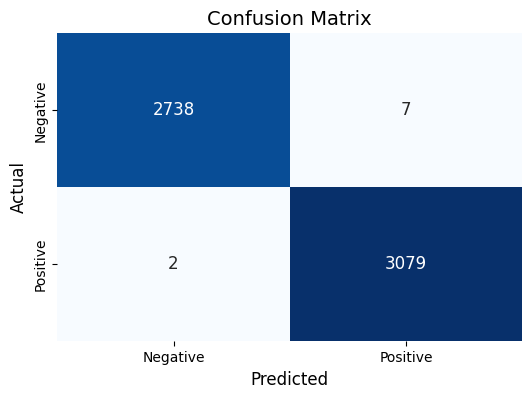

In [ ]:
# Plot confusion matrix

bi_cm = plot_confusion_matrix(y_test, bi_prediction)
bi_cm

In [ ]:
# Show results

bi_results = calculate_results_as_dataframe(y_test, bi_prediction)
bi_results["architecture"] = "LSTM Bidirectional RNN"
bi_results["tokenizer/vectorizer"] = "TextVectorization"
bi_results["embedding"] = "Keras Layer"

bi_results

,accuracy,precision,recall,f1,architecture,tokenizer/vectorizer,embedding
0,99.846%,0.998,0.998,0.998,LSTM Bidirectional RNN,TextVectorization,Keras Layer


In [ ]:
bi_results["model"] = "Bidirectional"
bi_results

,accuracy,precision,recall,f1,architecture,tokenizer/vectorizer,embedding,model
0,99.846%,0.998,0.998,0.998,LSTM Bidirectional RNN,TextVectorization,Keras Layer,Bidirectional


### CNN Model

In [ ]:
# Build the model

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

cnn_model = tf.keras.Model(inputs, outputs)

# Compile model
cnn_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
cnn_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 239)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 239, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 235, 32)           20512     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)                 33  

In [ ]:
# Fit the model

callbacks = [ModelCheckpoint(filepath='cnn_model', save_best_only=True, save_format='tf'),
             EarlyStopping(patience=4, monitor='val_loss', restore_best_weights = True),
             ReduceLROnPlateau(factor=0.2, patience=2, monitor='val_loss'),
             CSVLogger('cnn_training_log.csv')]


cnn_modell_history = cnn_model.fit(X_train,
                                      y_train,
                                      epochs=20,
                                      validation_data=(X_val, y_val),
                                      callbacks=callbacks)

Epoch 1/20
850/850 [==============================] - 66s 76ms/step - loss: 0.0214 - accuracy: 0.9951 - val_loss: 0.0643 - val_accuracy: 0.9782 - lr: 0.0010
Epoch 2/20
850/850 [==============================] - 57s 68ms/step - loss: 0.0120 - accuracy: 0.9970 - val_loss: 0.0167 - val_accuracy: 0.9959 - lr: 0.0010
Epoch 3/20
850/850 [==============================] - 56s 66ms/step - loss: 0.0068 - accuracy: 0.9981 - val_loss: 0.0196 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 4/20
850/850 [==============================] - 64s 75ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0179 - val_accuracy: 0.9961 - lr: 0.0010
Epoch 5/20
850/850 [==============================] - 69s 81ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0124 - val_accuracy: 0.9961 - lr: 2.0000e-04
Epoch 6/20
850/850 [==============================] - 56s 65ms/step - loss: 5.5350e-04 - accuracy: 0.9999 - val_loss: 0.0122 - val_accuracy: 0.9959 - lr: 2.0000e-04
Epoch 7/20
850/850 [==========================

In [ ]:
# Make predictions on input data (X_test) in form of probabilities

cnn_probabilities = cnn_model.predict(X_test)
cnn_probabilities[:5]

183/183 [==============================] - 3s 16ms/step


array([[9.9998367e-01],
       [3.1690437e-17],
       [1.9120135e-08],
       [9.9999344e-01],
       [9.9996114e-01]], dtype=float32)

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats

# squeeze removes single dimensions
cnn_prediction = tf.squeeze(tf.round(cnn_probabilities))
cnn_prediction[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 1., 1., 0., 0., 1., 1., 1.], dtype=float32)>

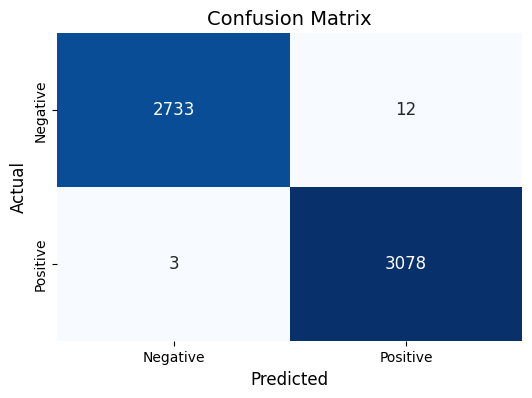

In [ ]:
# Plot confusion matrix

cnn_cm = plot_confusion_matrix(y_test, cnn_prediction)
cnn_cm

In [ ]:
# Show results

cnn_results = calculate_results_as_dataframe(y_test, cnn_prediction)

cnn_results

,accuracy,precision,recall,f1
0,99.743%,0.997,0.997,0.997


In [ ]:
cnn_results["model"] = "CNN"
cnn_results["architecture"] = "Basic CNN"
cnn_results["tokenizer/vectorizer"] = "TextVectorization"
cnn_results["embedding"] = "Keras Layer"

cnn_results

,accuracy,precision,recall,f1,model,architecture,tokenizer/vectorizer,embedding
0,99.743%,0.997,0.997,0.997,CNN,Basic CNN,TextVectorization,Keras Layer


### Gensim Model

In order to train the Gensim model we have to tokenize with `text_to_word_sequence` instead of `TextVectorization`, and download the Word2Vec embedding. For this model the `glove-wiki-gigaword-50` embeddings were used

In [ ]:
# Create a new train/test/validation set with text_to_word_sequence library for toketization

def text_to_word_tokenizer(shuffled_df, random_seed = random_seed):

    # Shuffle the DataFrame with the specified random seed
    print(shuffled_df.shape)

    # Split the data into sentences and labels
    sentences = shuffled_df['combined_features'].tolist()
    labels = shuffled_df['label'].tolist()

    # Tokenize the sentences
    X = [text_to_word_sequence(sentence) for sentence in sentences]

    return X, labels


# Load the data from the CSV file
X, y = text_to_word_tokenizer(shuffled_df, random_seed)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state = random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state = random_seed)


(38835, 4)


In [ ]:
# Display the length of the train, validation, and test sets

print("X_train shape:", len(X_train))
print("X_validation shape:", len(X_val))
print("X_test shape:", len(X_test))

X_train shape: 27184
X_validation shape: 5825
X_test shape: 5826


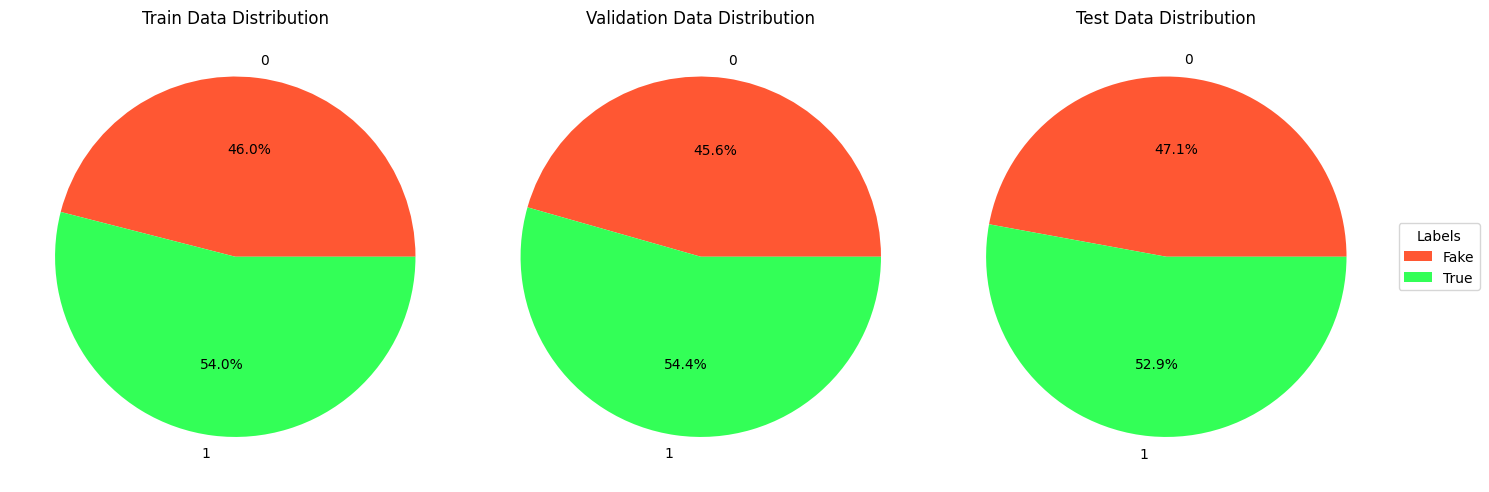

In [ ]:
# Check label distribution

# Calculate label counts for train, validation, and test data
train_labels, train_label_counts = np.unique(y_train, return_counts=True)
val_labels, val_label_counts = np.unique(y_val, return_counts=True)
test_labels, test_label_counts = np.unique(y_test, return_counts=True)

# Define custom colors
colors = ['#FF5733', '#33FF57']

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1: Train data distribution
wedges, texts, autotexts = axes[0].pie(train_label_counts, labels=train_labels, autopct='%1.1f%%', colors=colors)
axes[0].set_title('Train Data Distribution')

# Subplot 2: Validation data distribution
wedges, texts, autotexts = axes[1].pie(val_label_counts, labels=val_labels, autopct='%1.1f%%', colors=colors)
axes[1].set_title('Validation Data Distribution')

# Subplot 3: Test data distribution
wedges, texts, autotexts = axes[2].pie(test_label_counts, labels=test_labels, autopct='%1.1f%%', colors=colors)
axes[2].set_title('Test Data Distribution')

# Add a legend manually
legend_labels = ['Fake', 'True']
axes[2].legend(legend_labels, title="Labels", loc="center left", bbox_to_anchor=(1, 0.5))

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
# Embedding

# Load a Word2Vec embedding
word2vec_transfer = api.load("glove-wiki-gigaword-50")

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])

    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []

    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)

    return embed

In [ ]:
# Padding

# Embed the training and test sentences
X_train_embed = embedding(word2vec_transfer, X_train)
X_val_embed = embedding(word2vec_transfer, X_val)
X_test_embed = embedding(word2vec_transfer, X_test)

# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=128)
X_val_pad = pad_sequences(X_val_embed, dtype='float32', padding='post', maxlen=128)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=128)

# Transform labels to numpy array
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
# Fit the model

# Function to compile the model
def init_gensim_model():
    model = Sequential()
    model.add(Bidirectional(layers.LSTM(64)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Model fitting

gensim_model = init_gensim_model()


callbacks = [ModelCheckpoint(filepath='gen_model', save_best_only=True, save_format='tf'),
             EarlyStopping(patience=4, monitor='val_loss', restore_best_weights = True),
             ReduceLROnPlateau(factor=0.2, patience=2, monitor='val_loss'),
             CSVLogger('gen_training_log.csv')]

gensim_model.fit(X_train_pad, y_train,
          epochs=20,
          batch_size=256,
          validation_data=(X_val_pad, y_val),
          callbacks=callbacks
         )


res = gensim_model.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

Epoch 1/20
107/107 [==============================] - 85s 736ms/step - loss: 0.2411 - accuracy: 0.9105 - val_loss: 0.1650 - val_accuracy: 0.9342 - lr: 0.0010
Epoch 2/20
107/107 [==============================] - 76s 717ms/step - loss: 0.1302 - accuracy: 0.9501 - val_loss: 0.1265 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 3/20
107/107 [==============================] - 76s 713ms/step - loss: 0.1066 - accuracy: 0.9595 - val_loss: 0.1096 - val_accuracy: 0.9578 - lr: 0.0010
Epoch 4/20
107/107 [==============================] - 80s 750ms/step - loss: 0.0894 - accuracy: 0.9673 - val_loss: 0.1056 - val_accuracy: 0.9641 - lr: 0.0010
Epoch 5/20
107/107 [==============================] - 83s 781ms/step - loss: 0.0771 - accuracy: 0.9717 - val_loss: 0.0923 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 6/20
107/107 [==============================] - 76s 710ms/step - loss: 0.0661 - accuracy: 0.9765 - val_loss: 0.0795 - val_accuracy: 0.9724 - lr: 0.0010
Epoch 7/20
107/107 [==============================] 

In [ ]:
gen_probabilities = gensim_model.predict(X_test_pad)
gen_probabilities[:5]

183/183 [==============================] - 9s 46ms/step


array([[9.9926543e-01],
       [2.1692847e-06],
       [1.1341193e-04],
       [9.9995929e-01],
       [9.9564135e-01]], dtype=float32)

In [ ]:
gen_prediction = tf.squeeze(tf.round(gen_probabilities))
gen_prediction[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 1., 1., 0., 0., 1., 1., 1.], dtype=float32)>

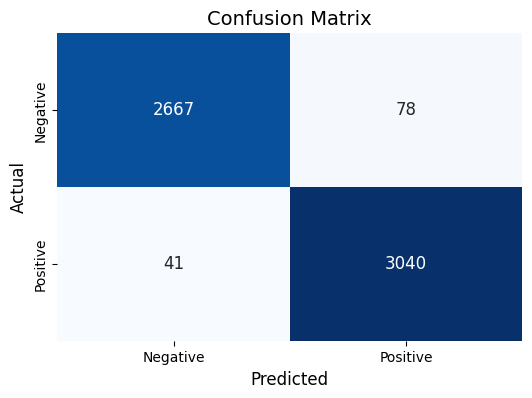

In [ ]:
# Plot confusion matrix

gen_cm = plot_confusion_matrix(y_test, gen_prediction)
gen_cm

In [ ]:
gen_results = calculate_results_as_dataframe(y_test, gen_prediction)

gen_results

,accuracy,precision,recall,f1
0,97.957%,0.980,0.980,0.980


In [ ]:
gen_results["model"] = "Gensim Glove"
gen_results["architecture"] = "LSTM Bidirectional RNN"
gen_results["tokenizer/vectorizer"] = "text_to_word_sequence"
gen_results["embedding"] = "Glove Word2Vec"

gen_results

,accuracy,precision,recall,f1,model,architecture,tokenizer/vectorizer,embedding
0,97.957%,0.980,0.980,0.980,Gensim Glove,LSTM Bidirectional RNN,text_to_word_sequence,Glove Word2Vec


## Models Comparison

In [ ]:
model_comparison = pd.concat([baseline_results, keras_results, lstm_results, gru_results, bi_results, cnn_results, gen_results]).sort_values(by="accuracy", ascending=False).set_index("model")

model_comparison

,accuracy,precision,recall,f1,architecture,tokenizer/vectorizer,embedding
model,,,,,,,
Bidirectional,99.846%,0.998,0.998,0.998,LSTM Bidirectional RNN,TextVectorization,Keras Layer
GRU,99.811%,0.998,0.998,0.998,LSTM GRU RNN,TextVectorization,Keras Layer
CNN,99.743%,0.997,0.997,0.997,Basic CNN,TextVectorization,Keras Layer
LSTM,99.279%,0.993,0.993,0.993,LSTM RNN,TextVectorization,Keras Layer
Basic Keras,99.073%,0.991,0.991,0.991,Basic RNN,TextVectorization,Keras Layer
Gensim Glove,97.957%,0.980,0.980,0.980,LSTM Bidirectional RNN,text_to_word_sequence,Glove Word2Vec
Baseline Gridsearch,93.855%,0.939,0.939,0.939,Multinomial Naive Bayes,TfidfVectorizer,None


In [ ]:
model_comparison.to_csv('model_comparison.csv')

# Download Best Model

In [ ]:
!zip -r bi_model.zip /content/bi_model

  adding: content/bi_model/ (stored 0%)
  adding: content/bi_model/saved_model.pb (deflated 74%)
  adding: content/bi_model/variables/ (stored 0%)
  adding: content/bi_model/variables/variables.index (deflated 57%)
  adding: content/bi_model/variables/variables.data-00000-of-00001 (deflated 5%)
  adding: content/bi_model/fingerprint.pb (stored 0%)
  adding: content/bi_model/keras_metadata.pb (deflated 86%)
  adding: content/bi_model/assets/ (stored 0%)


In [ ]:
files.download('bi_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>